### PCA and NMF

This notebook does some preliminary work running Eigenfaces through PCA and NMF. The process is seeded and the outputs are written to CSVs for downstream modeling. 

Eventually I may want to write the code so that the dimension reduction method is modular and can be swapped out easily. 

In [1]:
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
from preprocess_data import EigenfacesDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
INPUT_SIZE = 120 * 128
NUM_EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 1e-3

n_components = 20
seed = 1

In [5]:
normalize_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
eigenfaces_dataset = EigenfacesDataset(
    data_dir='../data',
    label='head_position',
    transform=normalize_transform)
trainset, testset = random_split(
    eigenfaces_dataset, [BATCH_SIZE * 10, len(eigenfaces_dataset) - BATCH_SIZE * 10])

In [6]:
train_loader = DataLoader(trainset)
test_loader = DataLoader(testset)

In [7]:
eigenfaces_dataloader = DataLoader(eigenfaces_dataset)

In [10]:
num_pixels = 120 * 128
data = np.empty((0, num_pixels))

# Iterate over the batches
for batch in eigenfaces_dataloader:
    # Flatten the batch
    batch = batch.view(batch.size(0), -1)
    # Convert the batch to a NumPy array
    batch = batch.numpy()
    # Center the batch around the mean
    batch = center_data(batch)
    # Concatenate the batch with the rest of the data
    data = np.concatenate((data, batch), axis=0)

AttributeError: 'list' object has no attribute 'view'

In [53]:
eigenfaces_dataloader.dataset[0][0].shape

torch.Size([120, 128])

In [28]:
eigenfaces_dataset.get_classes(label="head_position")

['straight', 'left', 'right', 'up']

In [31]:
head_positions = []
for i in range(len(eigenfaces_dataset)):
    _, label_idx = eigenfaces_dataset[i]
    head_position = eigenfaces_dataset.classes[label_idx]
    head_positions.append(head_position)

# Print the collected head positions
print(head_positions)

['left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'straight', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'straight', 'straight',

In [33]:
len(head_positions)

624

In [11]:
flattened_tensors_list = []

# Flatten the tensors and add them to the list
for tensor_list in eigenfaces_dataloader:
    flattened_tensors = tensor_list[0].view(tensor_list[0].size(0), -1)
    flattened_tensors_list.append(flattened_tensors)

# Concatenate the flattened tensors into one dataset
dataset = torch.cat(flattened_tensors_list, dim=0)

# dataset now contains all the flattened tensors concatenated into one dataset


In [12]:
flattened_tensors_list

[tensor([[-0.7333, -0.9765, -0.9922,  ..., -0.3725, -0.6863, -1.0000]]),
 tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.9765, -1.0000, -1.0000]]),
 tensor([[-0.7333, -0.9765, -1.0000,  ..., -0.9529, -0.9922, -1.0000]]),
 tensor([[-0.7255, -0.9765, -0.9922,  ..., -0.9686, -1.0000, -1.0000]]),
 tensor([[-0.6157, -0.1451, -0.0824,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[-0.7098, -0.9765, -0.9765,  ..., -0.9529, -1.0000, -1.0000]]),
 tensor([[-0.7490, -0.9922, -0.9922,  ..., -0.9686, -1.0000, -1.0000]]),
 tensor([[-0.7098, -0.9765, -0.9922,  ..., -0.9686, -1.0000, -1.0000]]),
 tensor([[-0.7176, -0.9765, -0.9922,  ...,  0.1608,  0.1608, -0.3961]]),
 tensor([[-0.7098, -0.9765, -0.9922,  ..., -0.9529, -1.0000, -1.0000]]),
 tensor([[-0.7333, -0.9765, -0.9922,  ..., -0.1137, -0.4039, -0.5451]]),
 tensor([[-0.7020, -0.9765, -0.9765,  ..., -0.9373, -1.0000, -1.0000]]),
 tensor([[-0.6078, -0.1216, -0.0667,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[-0.6941, -0.9765, -0.9922,  ..., -0.9294,

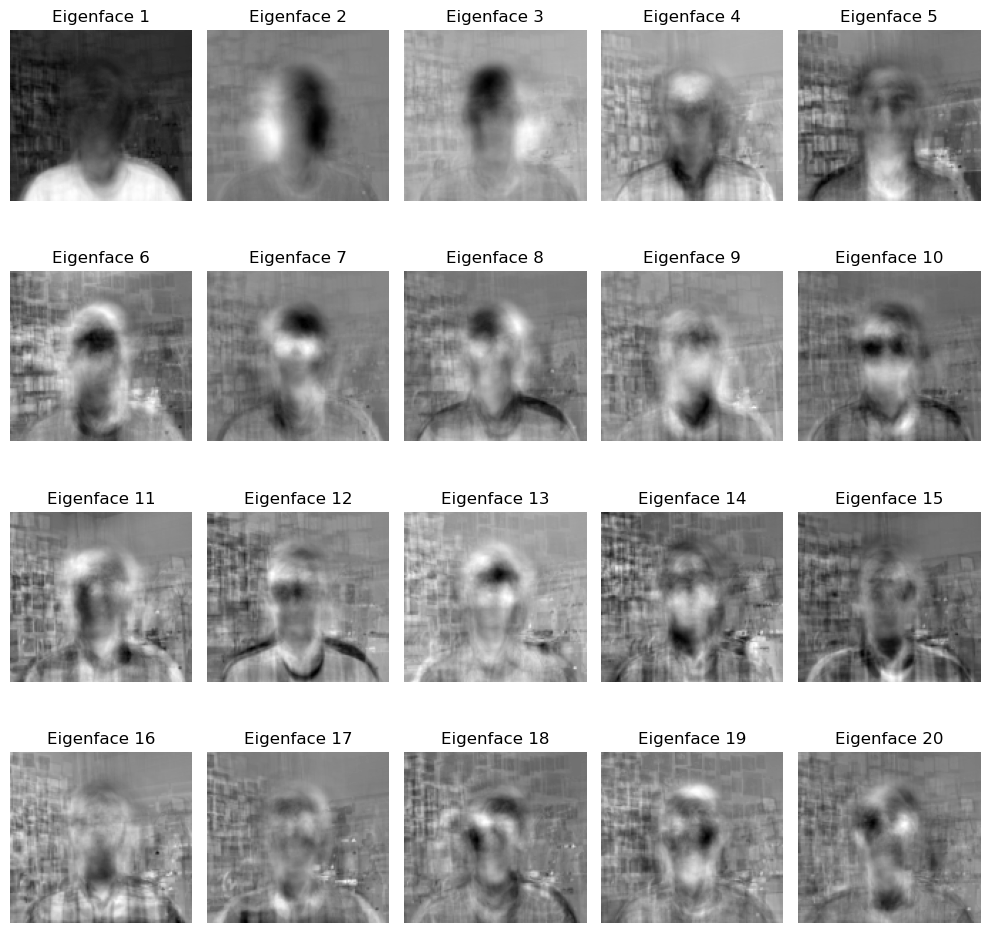

In [17]:
# Flatten the data
flat_tensors = []
for tensor_list in eigenfaces_dataloader:
    flattened_tensors = torch.flatten(tensor_list[0].squeeze())
    flat_tensors.append(flattened_tensors)
    # print(torch.flatten(tensor_list[0].squeeze()).shape)
    
flat_data = torch.stack([t.view(-1) for t in flat_tensors])

# Convert the tensor to a numpy array
data = flat_data.numpy()

# Create a PCA object with the desired number of components
pca = PCA(n_components=n_components)

# Fit the PCA model to the data
pca.fit(data)

# Get the principal components
components = pca.components_

eigenfaces = components.reshape(-1, 1, 120, 128)

# Plot the eigenfaces
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[i, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Eigenface {i+1}")
plt.tight_layout()
plt.show()


/Users/jacobchang/miniforge3/envs/default_dev/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


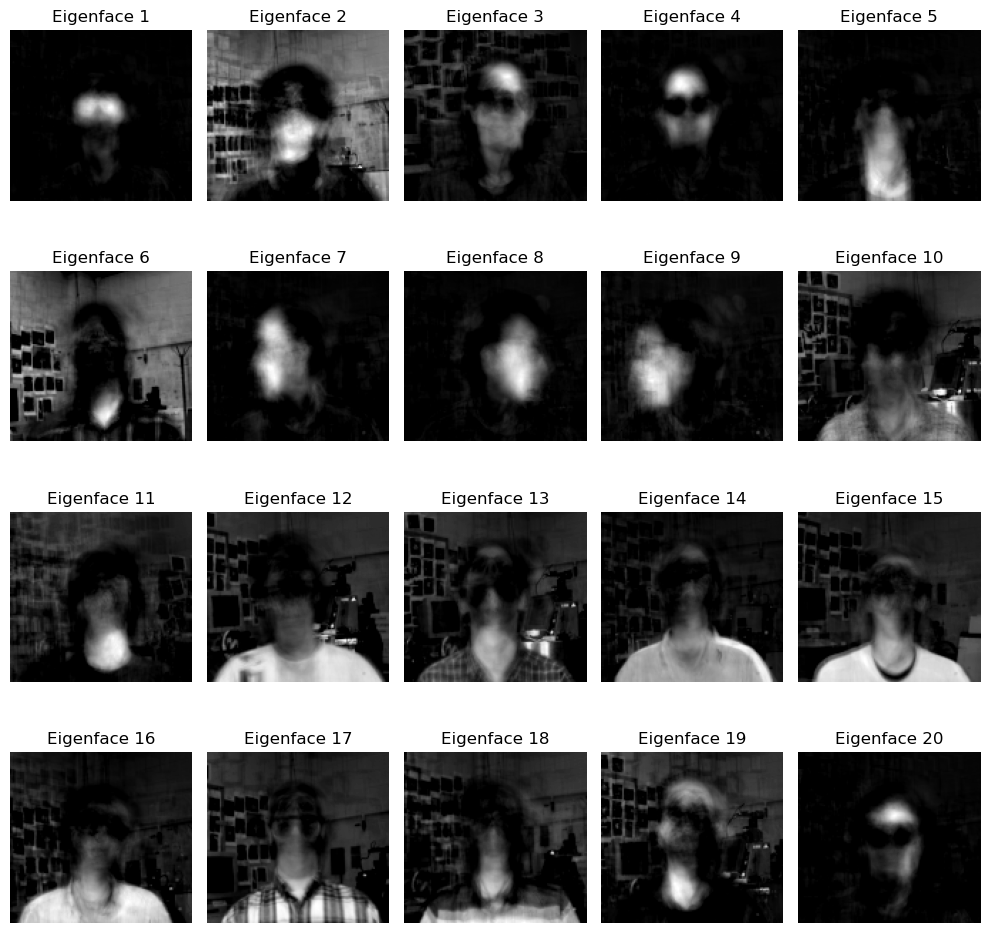

In [19]:
import numpy as np
import torch
from sklearn.decomposition import NMF

# Assume `tensors` is a list of PyTorch tensors

# Flatten each tensor and stack them into a single tensor
flat_tensors = []
for tensor_list in eigenfaces_dataloader:
    flattened_tensors = torch.flatten(tensor_list[0].squeeze())
    flat_tensors.append(flattened_tensors)
    # print(torch.flatten(tensor_list[0].squeeze()).shape)
flat_data = torch.stack([t.view(-1) for t in flat_tensors])

# Convert the tensor to a numpy array
data = flat_data.numpy()

# Create an NMF object with the desired number of components
nmf = NMF(n_components=n_components, random_state=seed)

# Shift the data to be non-negative
data_min = np.min(data)
if data_min < 0:
    data -= data_min

# Fit the NMF model to the data
W = nmf.fit_transform(data)
H = nmf.components_

# Get the basis vectors (i.e., the "eigenfaces")
eigenfaces = H.reshape(-1, 1, 120, 128)

# Plot the eigenfaces
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[i, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Eigenface {i+1}")
plt.tight_layout()
plt.show()


In [21]:
H.reshape(-1, 1, 120, 128).shape

(20, 1, 120, 128)

In [23]:
W.shape

(624, 20)

In [24]:
labels

NameError: name 'labels' is not defined

In [41]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# Assuming you have a labels array containing the orientations
X_train, X_test, y_train, y_test = train_test_split(W, head_positions, test_size=0.2, random_state=42)

# Create an SVM classifier
clf = svm.SVC()

# Train the SVM classifier
clf.fit(X_train, y_train)


SVC()

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict orientations for test set
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Confusion Matrix:
[[19  6  5  3]
 [ 0 18  2  6]
 [ 3  6 20  4]
 [ 1  3  3 26]]
Accuracy: 0.664


In [37]:
W.shape

(624, 20)

In [38]:
type(head_position)

str

In [40]:
head_positions

['left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'straight',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'up',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 'left',
 